In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr
from tqdm import tqdm
import numpy as np 
import math
import seaborn as sns
from scipy.stats import ttest_ind


demos = ['women', 'black', 'hispanic', 'native american']
%matplotlib inline

### 1. Startup

In [2]:
def startup(start, end):
    """ 
    Takes in a start and end year and returns a dictionary of dataframes. Read in data from 
    IPEDS completions, university meta-data and demographic columns of interest.
    """
    
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    unis = unis.set_index('UNITID')

    completions = {}
    for year in range(start, end+1):
        data              = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
        data              = data.set_index('UNITID')
        data              = data[data['AWLEVEL'] == 5]
        completions[year] = data

    demo_cols = ['CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    
    return unis, completions, demo_cols

unis, completions, demo_cols = startup(2011, 2021)

### 2. CS & NonCS

In [3]:
def cs_noncs(data):

    cs_map      = data['CIPCODE'].apply(lambda x : 11 <= x and x < 12)
    cs          = data[cs_map]
    cs_sum      = cs.groupby('UNITID').sum()

    noncs_map   = ~cs_map
    noncs       = data[noncs_map]
    noncs_sum   = noncs.groupby('UNITID').sum()

    cs_unis     = set(cs_sum.index.unique())
    noncs_unis  = set(noncs_sum.index.unique())
    common_unis = list(cs_unis.intersection(noncs_unis))

    cs_sum      = cs_sum.loc[common_unis]
    noncs_sum   = noncs_sum.loc[common_unis]

    return cs_sum, noncs_sum

def cs_noncs_allyears(completions):

    all_cs      = []
    all_noncs   = []
    
    for year in completions:
        data          = completions[year]
        cs, noncs     = cs_noncs(data)

        cs['year']    = year
        noncs['year'] = year

        all_cs.append(cs)
        all_noncs.append(noncs)
        
    all_cs    = pd.concat(all_cs)
    all_noncs = pd.concat(all_noncs)
    return all_cs, all_noncs

cs, noncs = cs_noncs_allyears(completions)

### 3. Compute Demographic Percentages

In [4]:
def make_percents(cs, noncs, demo_cols):
    cs      = cs.set_index(['year'], append=True)
    noncs   = noncs.set_index(['year'], append=True)

    cs_pct      = cs.apply(lambda x:    x[demo_cols] / x['CTOTALT'], axis = 1)
    noncs_pct   = noncs.apply(lambda x: x[demo_cols] / x['CTOTALT'], axis = 1)

    return cs_pct, noncs_pct

cs_pct, noncs_pct = make_percents(cs, noncs, demo_cols)


### 4. Compute _"Trend"_ correlation measure

In [5]:
cs_pct        = cs_pct.reset_index(level=1)
noncs_pct     = noncs_pct.reset_index(level=1)

cs_pct        = cs_pct.dropna()
noncs_pct     = noncs_pct.dropna()

years_of_data = cs_pct.groupby('UNITID').count()['year']
all_11_years  = years_of_data[years_of_data == 11].index
cs_pct        = cs_pct.loc[all_11_years]

years_of_data = noncs_pct.groupby('UNITID').count()['year']
all_11_years  = years_of_data[years_of_data == 11].index
noncs_pct     = noncs_pct.loc[all_11_years]


In [6]:
cols          = [('black', 'CBKAAT'), ('women', 'CTOTALW'), ('hispanic', 'CHISPT')]

for label, col in cols:

    cs_trends    = cs_pct.groupby('UNITID').apply(lambda x: pearsonr(x['year'], x[col]))
    cs_trends    = cs_trends.apply(lambda x: pd.Series({'cs_stat': x[0], 'cs_pval': x[1]}))

    noncs_trends = noncs_pct.groupby('UNITID').apply(lambda x: pearsonr(x['year'], x[col]))
    noncs_trends = noncs_trends.apply(lambda x: pd.Series({'noncs_stat': x[0], 'noncs_pval': x[1]}))

    trends = pd.merge(cs_trends, noncs_trends, left_index=True, right_index=True)

    trends = trends.dropna()
    trends.loc['quadrant', :] = trends.apply(lambda x: 1 if x['cs_stat'] > 0 and x['noncs_stat'] > 0 else\
                                                2 if x['cs_stat'] < 0 and x['noncs_stat'] > 0 else\
                                                3 if x['cs_stat'] < 0 and x['noncs_stat'] < 0 else\
                                                4, axis=1)

    trends = trends.dropna()
    trends.to_csv('../../out/trends_%s.csv' % label)

/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages

### Old Code

In [6]:
def cs_nonCs_difference(cs, nonCs):
    difference = cs - nonCs
    difference.columns = ['d_%s' % col for col in difference.columns]
    return difference

In [7]:
def get_avg(data):
    data = data.reset_index()
    data = data.groupby('UNITID').mean()
    return data

In [8]:
def make_correlation_df(data, unis, demo):
    correlation_df_merge = pd.merge(data[['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], unis)
    non_differences = correlation_df_merge.drop(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT'], axis=1)
    correlations_df = non_differences.corrwith(correlation_df_merge[demo])
    return correlations_df.dropna()
    


In [9]:
def binarize(data, unis, col):
    series = unis[col]
    unique_vals = set(series.unique())
    #binarized_unis = pd.DataFrame()
    for value in unique_vals:
        data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)

In [10]:
def demo_df(all_unis):
    binarized_unis = pd.DataFrame()
    
    cols = ['SECTOR', 'INSTSIZE', 'UGOFFER', 'GROFFER', 'HBCU', 'HDEGOFR1', 'MEDICAL', 'LOCALE', 'C21BASIC', 'CBSATYPE', 'C21SZSET']
    for col in cols:
        binarize(binarized_unis, all_unis[2021], col)
    binarized_unis['UNITID'] = all_unis[2021]['UNITID']
    binarized_unis = binarized_unis.set_index('UNITID')
    return binarized_unis


In [11]:
def difference_df(difference, df):
    final_df = pd.merge(difference, df, left_index=True, right_index=True)

In [71]:


unis, all_completions, demo_names = startup()
cs_group, nonCs_group = groupTotals(years)
cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
# difference = cs_nonCs_difference(cs_percent, nonCs_percent)
# average = get_avg(difference)
binarized_unis = demo_df(all_unis)
# binarized_df = difference_df(average, binarized_unis)


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_99107/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_99107/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_99107/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [72]:
# cs_percent = cs_percent.reset_index()
# nonCs_percent = nonCs_percent.reset_index()
# cs_percent = cs_percent[cs_percent['year'] >= 2011]
# nonCs_percent = nonCs_percent[nonCs_percent['year'] >= 2011]

/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [95]:
unis = pd.read_csv('../../data/IPEDS/university_info/binarized_hd_2021.csv', index_col = 0)
unis_stats = pd.merge(unis, trends, left_index=True, right_index=True)
unis_stats = unis_stats.dropna()

In [96]:
unis_stats.sort_values('nonCs_stat')

SECTOR_0  SECTOR_1  SECTOR_2  SECTOR_3  SECTOR_4  SECTOR_5  SECTOR_6  \
UNITID                                                                         
135717         0         1         0         0         0         0         0   
190691         0         1         0         0         0         0         0   
190567         0         1         0         0         0         0         0   
134130         0         1         0         0         0         0         0   
190655         0         1         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
196060         0         1         0         0         0         0         0   
229115         0         1         0         0         0         0         0   
149772         0         1         0         0         0         0         0   
212115         0         1         0         0         0         0         0   
199148         0         1         0         0         0         0         0   

        SECTOR_7  SECTOR_8  SECTOR_9  ...  C21SZSET_14  C21SZSET_15  \
UNITID                                ...                             
135717         0         0         0  ...            0            1   
190691         0         0         0  ...            0            0   
190567         0         0         0  ...            0            1   
134130         0         0         0  ...            0            0   
190655         0         0         0  ...            0            1   
...          ...       ...       ...  ...          ...          ...   
196060         0         0         0  ...            0            0   
229115         0         0         0  ...            0            1   
149772         0         0         0  ...            0            0   
212115         0         0         0  ...            1            0   
199148         0         0         0  ...            0            0   

        C21SZSET_16  C21SZSET_17  C21SZSET_18  C21SZSET_-2   cs_stat  \
UNITID                                                                 
135717            0            0            0            0 -0.429268   
190691            0            0            0            0 -0.544193   
190567            0            0            0            0 -0.043815   
134130            1            0            0            0 -0.109790   
190655            0            0            0            0 -0.811795   
...             ...          ...          ...          ...       ...   
196060            0            1            0            0  0.903119   
229115            0            0            0            0  0.876539   
149772            0            0            0            0  0.274843   
212115            0            0            0            0  0.615625   
199148            1            0            0            0  0.275138   

         cs_pval  nonCs_stat    nonCs_pval  
UNITID                                      
135717  0.187658   -0.977488  2.183860e-07  
190691  0.083507   -0.974640  3.717482e-07  
190567  0.898218   -0.970409  7.398468e-07  
134130  0.747949   -0.968895  9.241042e-07  
190655  0.002410   -0.964829  1.596716e-06  
...          ...         ...           ...  
196060  0.000139    0.980449  1.162842e-07  
229115  0.000399    0.984700  3.881260e-08  
149772  0.413391    0.986946  1.906134e-08  
212115  0.043759    0.988748  9.794868e-09  
199148  0.412870    0.992084  2.022205e-09  

[1852 rows x 112 columns]

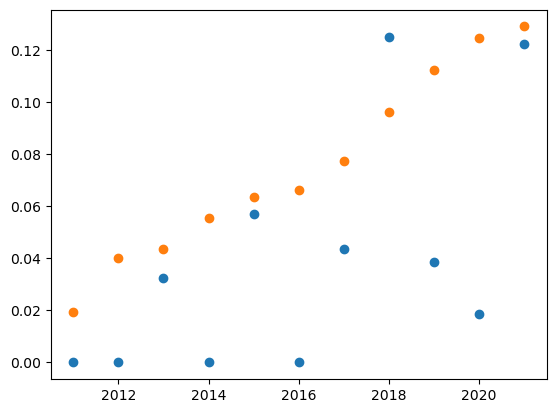

In [91]:
oneCs = cs_percent[cs_percent['UNITID'] == 212115]
one_nonCs = nonCs_percent[nonCs_percent['UNITID'] == 212115]
plt.scatter(oneCs['year'], oneCs['CBKAAT'])
plt.scatter(one_nonCs['year'], one_nonCs['CBKAAT'])


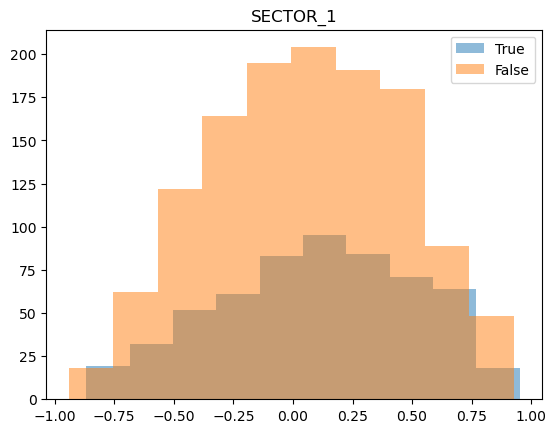

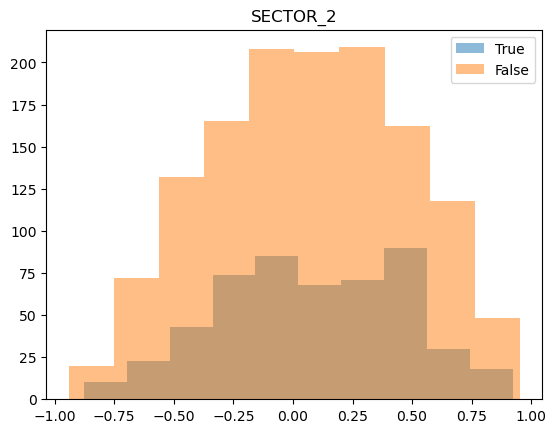

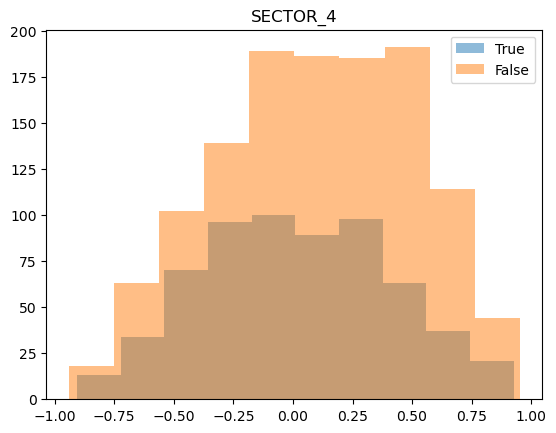

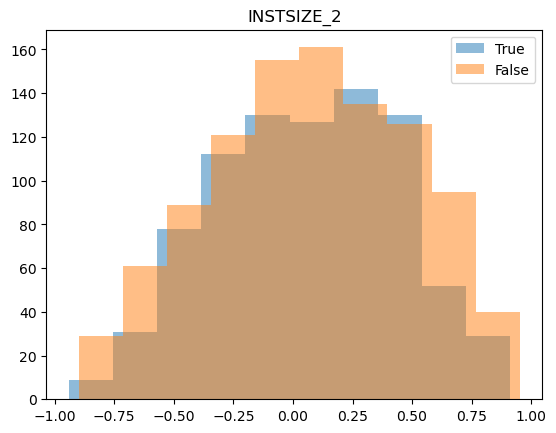

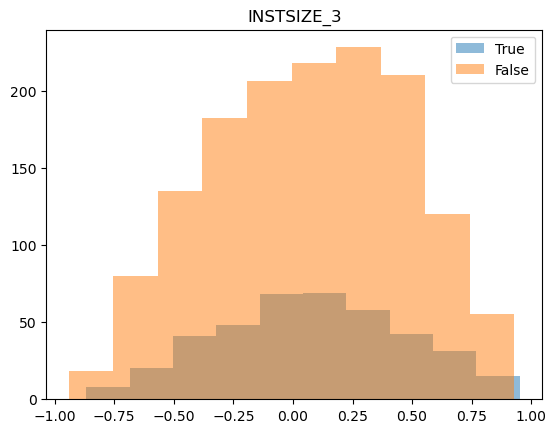

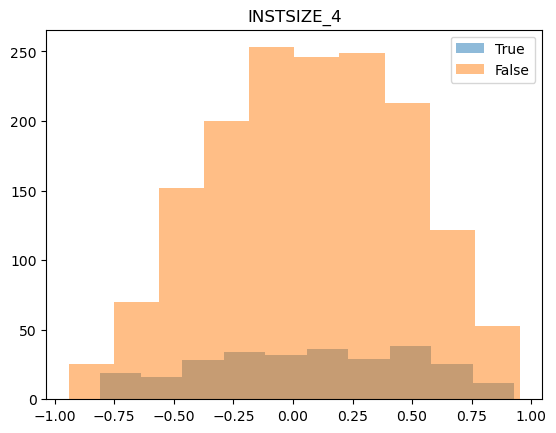

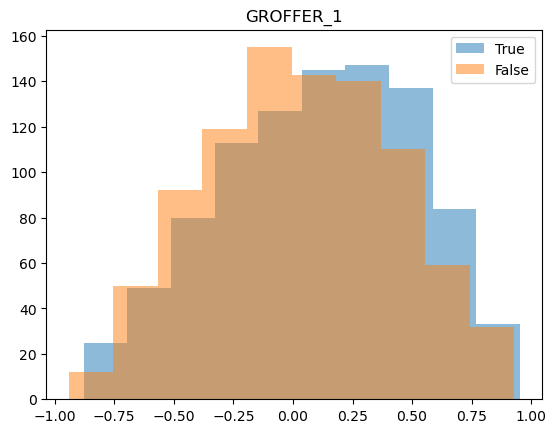

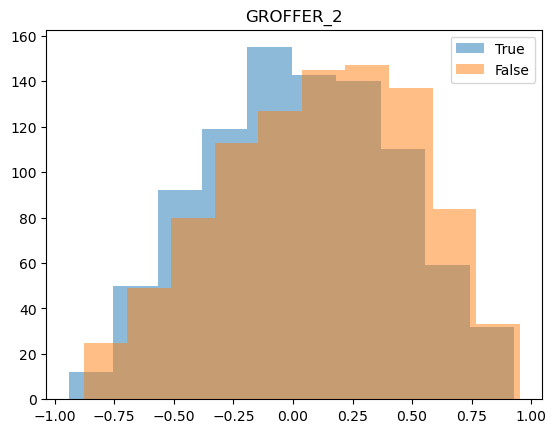

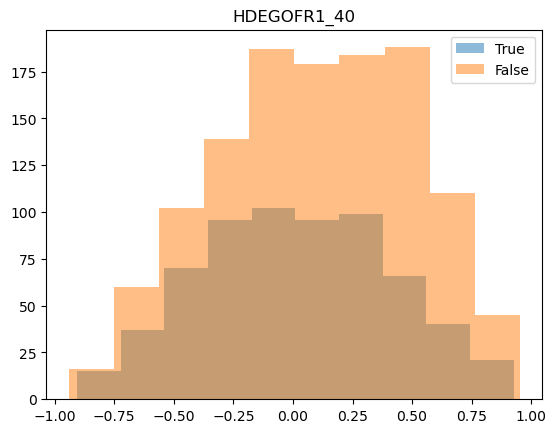

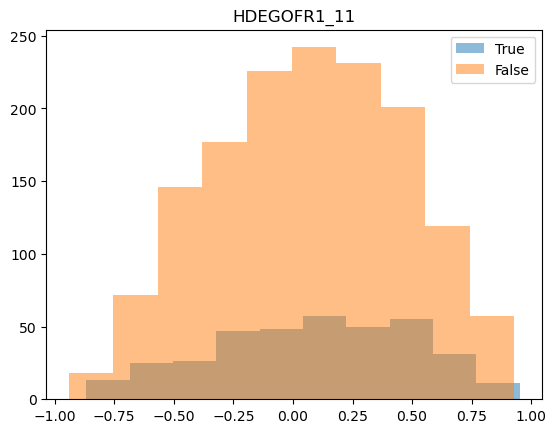

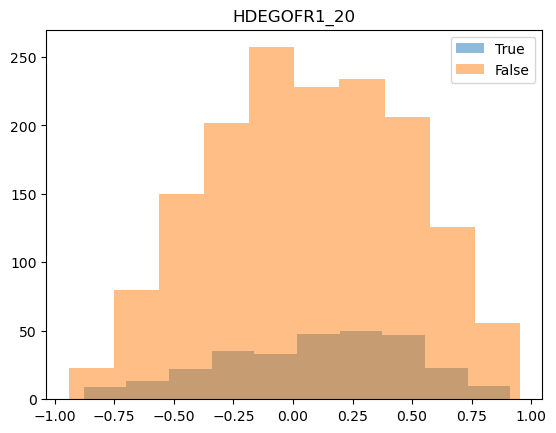

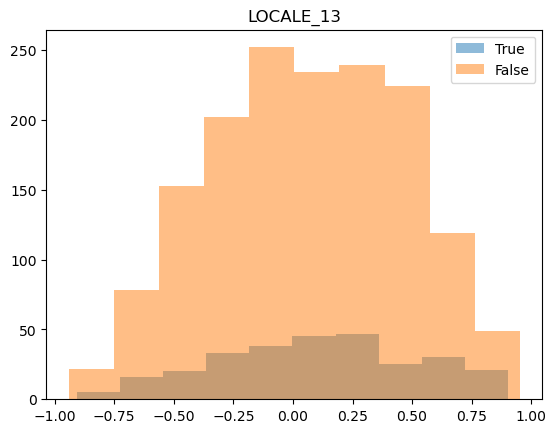

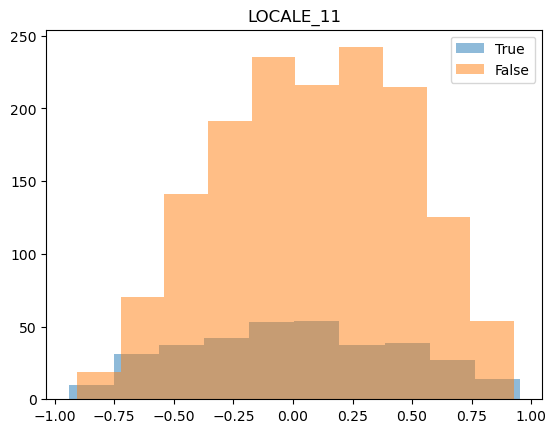

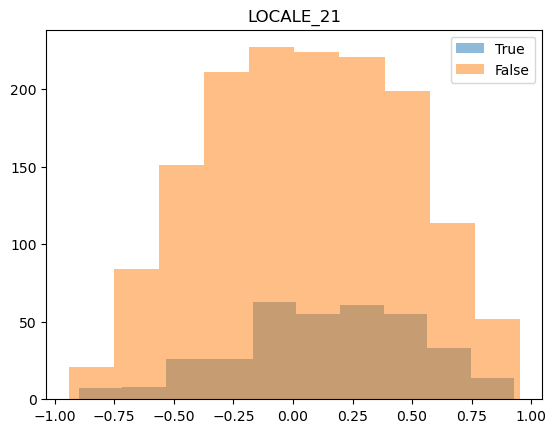

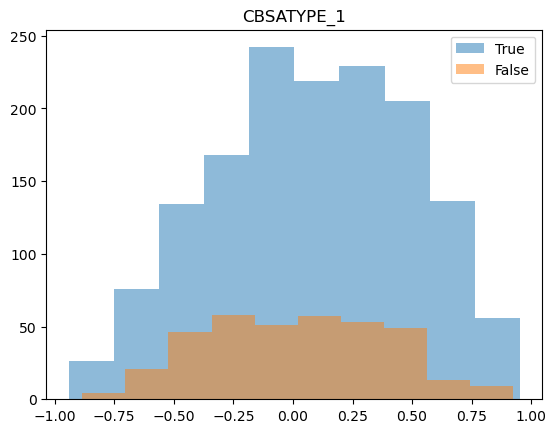

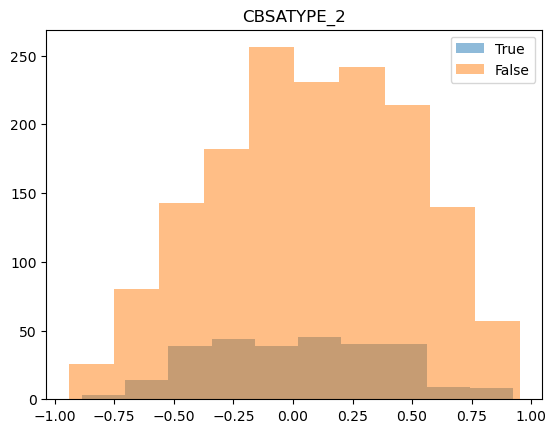

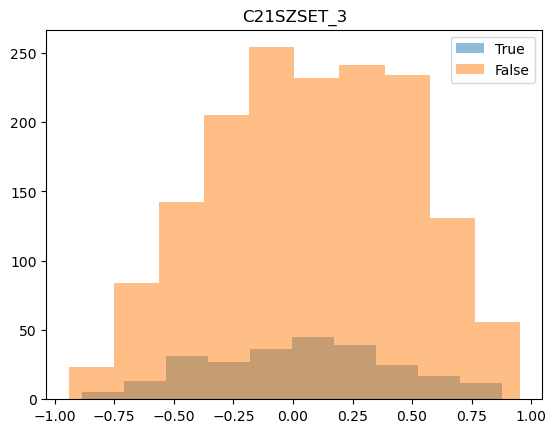

<Figure size 640x480 with 0 Axes>

In [103]:
demo_cols = ['d_CTOTALW', 'CBKAAT', 'CHISPT', 'CAIANT']
#for demo in demo_cols:
results = []
for col in binarized_unis.columns.unique():
    pos = unis_stats.loc[unis_stats[col] == 1, 'cs_stat']
    neg = unis_stats.loc[unis_stats[col] == 0, 'cs_stat']
    min_length = min(len(pos), len(neg))
    if min_length < 250:
        continue
    stat, pval = ttest_ind(pos, neg, equal_var=False, alternative='two-sided')
    results.append([col, pval])
results = pd.DataFrame(results)
results.columns = ['col', 'pval']
results = results.dropna()
results.sort_values('pval')
for col in results['col'].values:
    pos = unis_stats.loc[unis_stats[col] == 1, 'cs_stat']
    neg = unis_stats.loc[unis_stats[col] == 0, 'cs_stat']
    plt.hist(pos, alpha = 0.5, label = 'True')
    #plt.figure()
    plt.hist(neg, alpha = 0.5, label = 'False')
    #plt.yscale('log')
    plt.title(col)
    plt.legend()
    #plt.savefig('../../out/corr_hist/%s/%s_hist.png'% (demo, col))
    #plt.close()
    plt.figure()

col          pval
21    GROFFER_1  2.118833e-09
22    GROFFER_2  2.118833e-09
66  C21BASIC_15  2.662023e-08
1      SECTOR_1  1.418664e-07
30  HDEGOFR1_13  2.045336e-07
..          ...           ...
94   C21SZSET_6  8.382389e-01
3      SECTOR_3  9.062941e-01
39    LOCALE_32  9.681883e-01
41    LOCALE_41  9.884401e-01
58   C21BASIC_7  9.949407e-01

[99 rows x 2 columns]

/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_84571/844535096.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


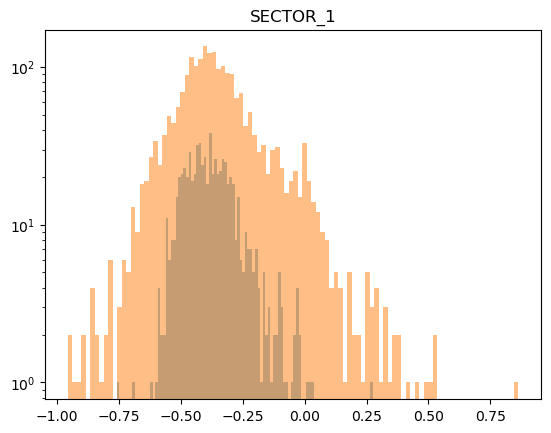

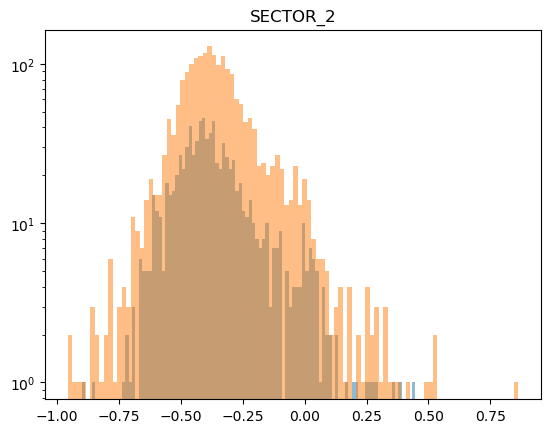

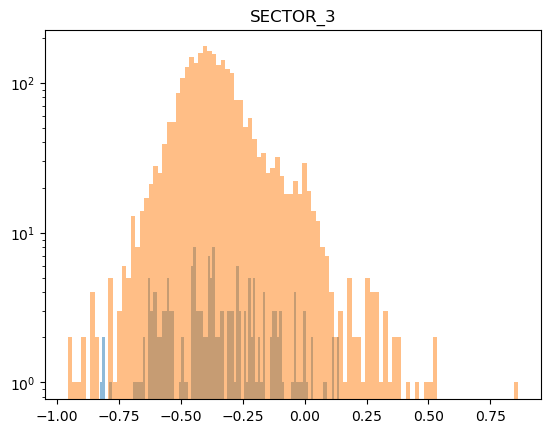

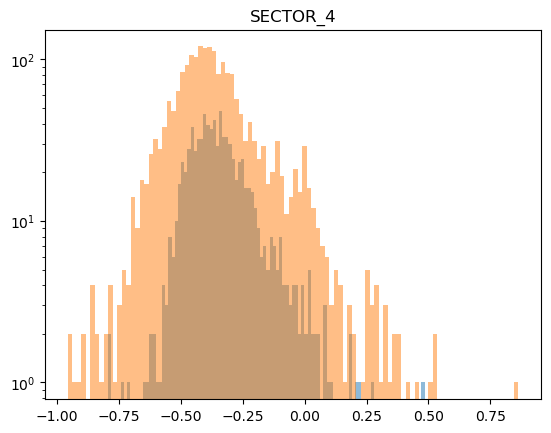

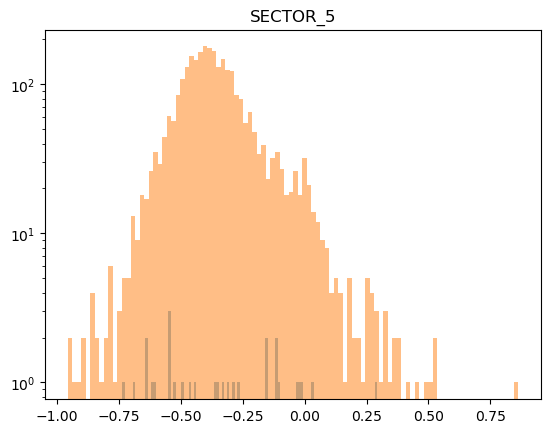

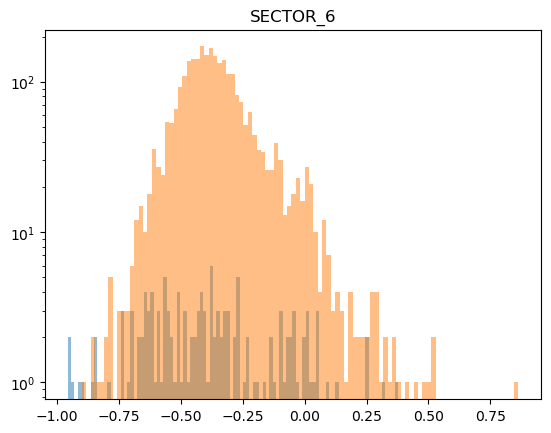

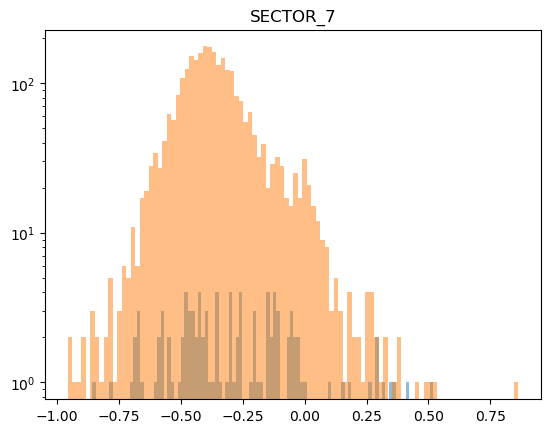

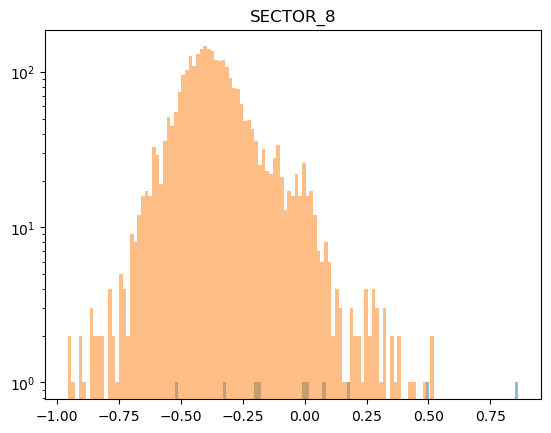

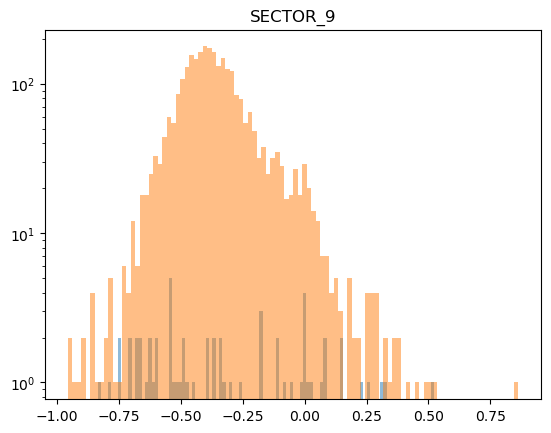

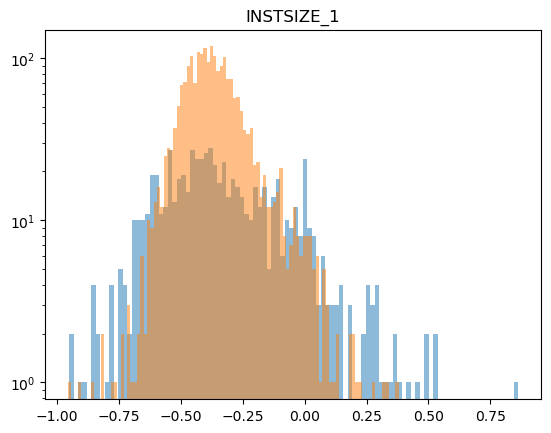

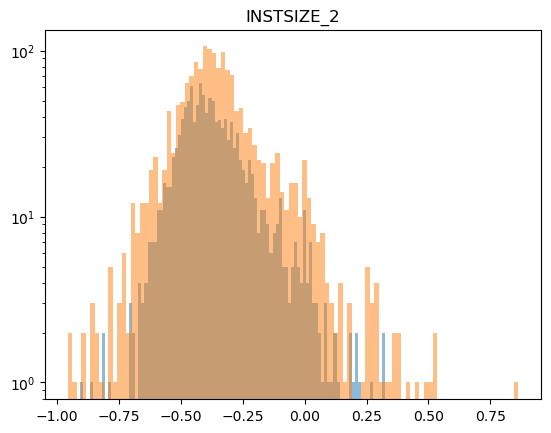

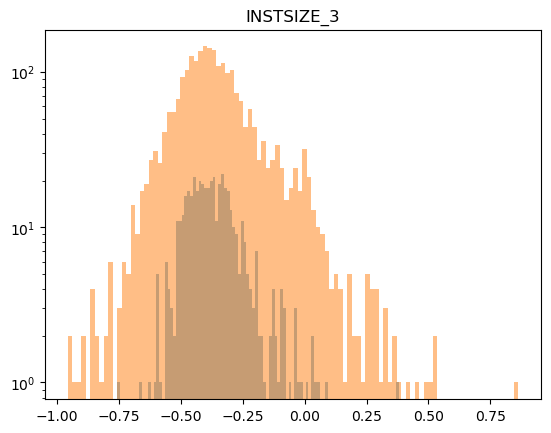

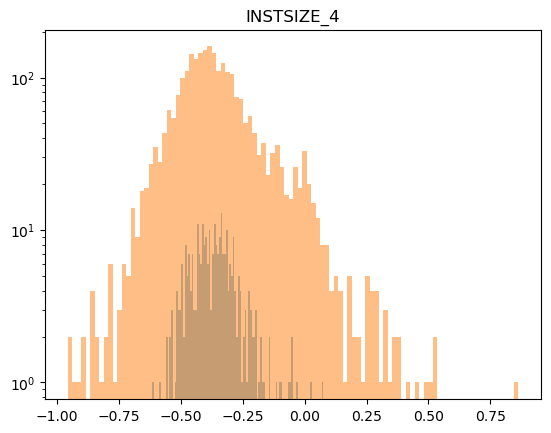

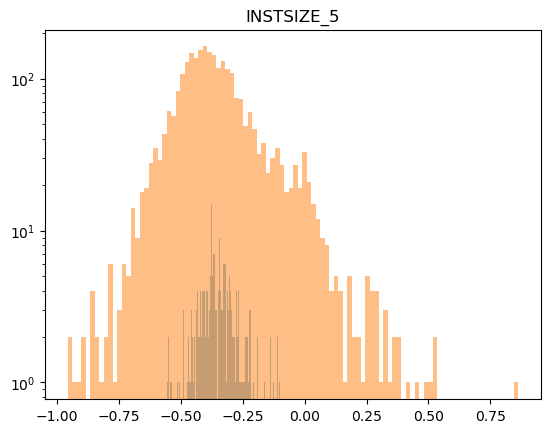

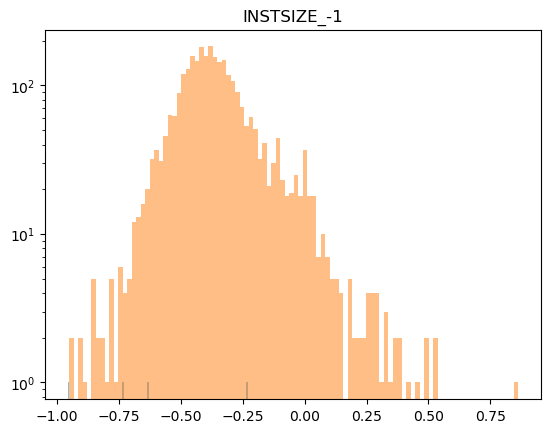

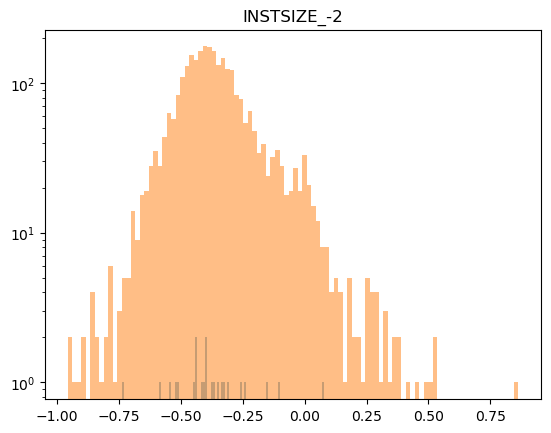

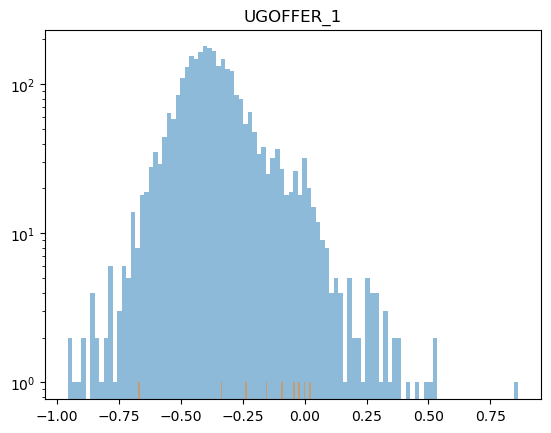

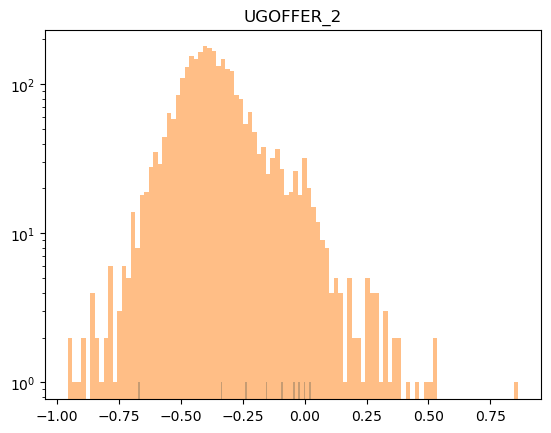

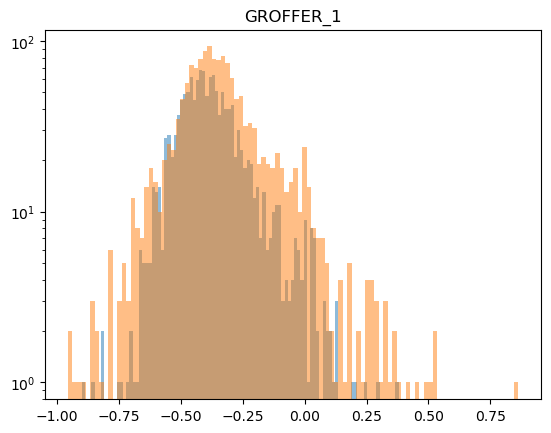

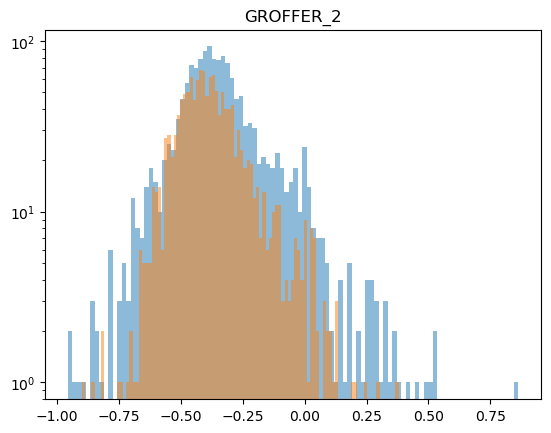

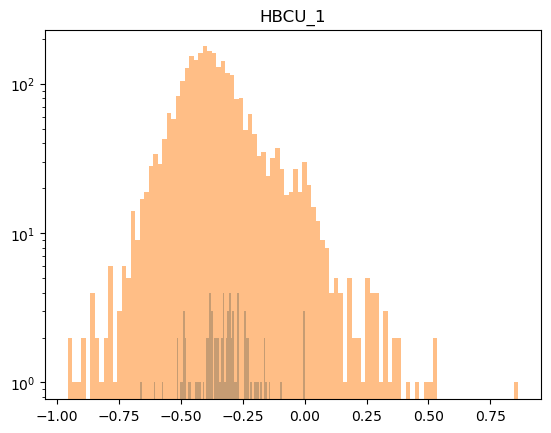

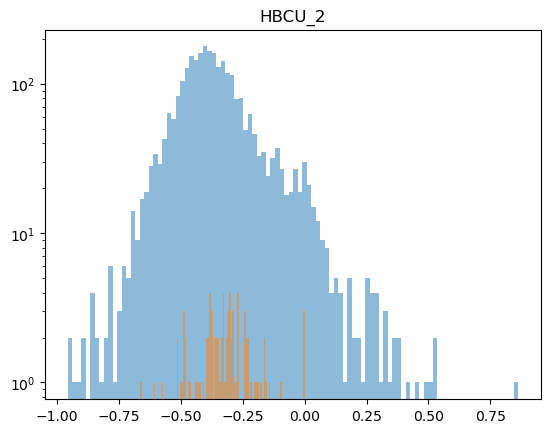

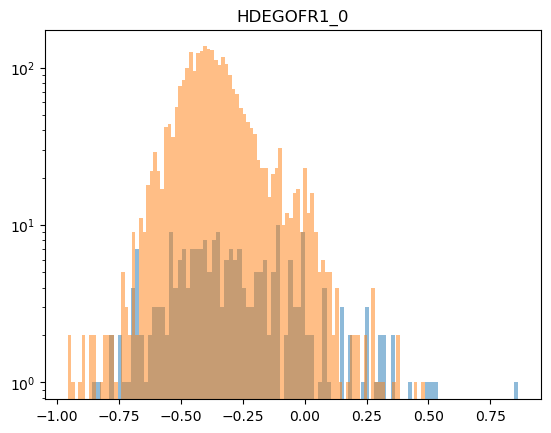

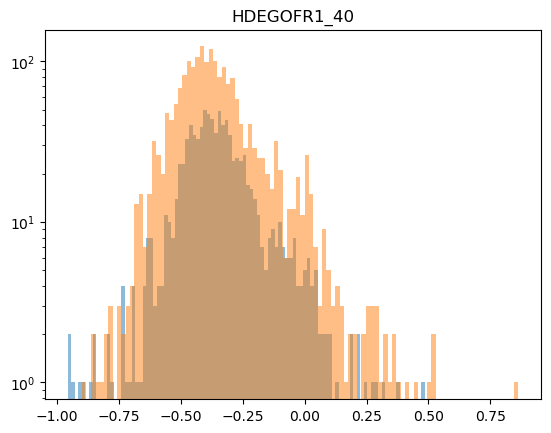

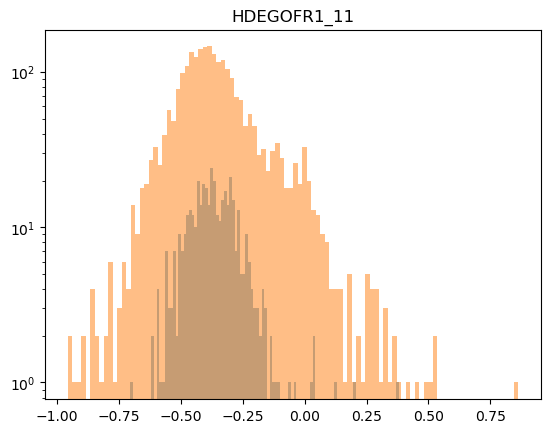

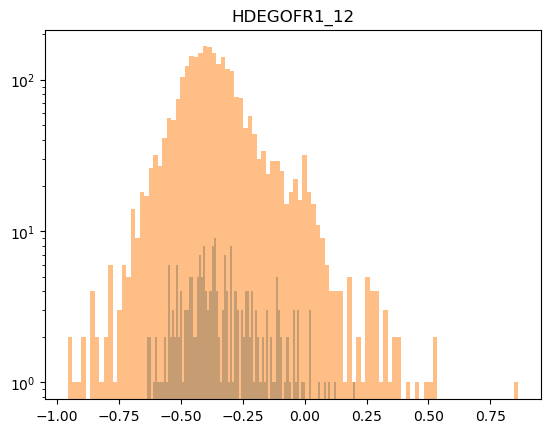

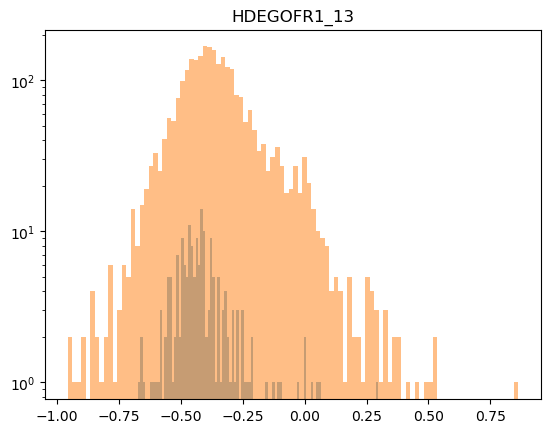

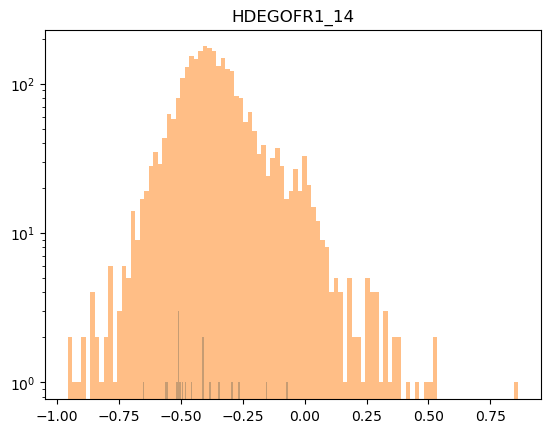

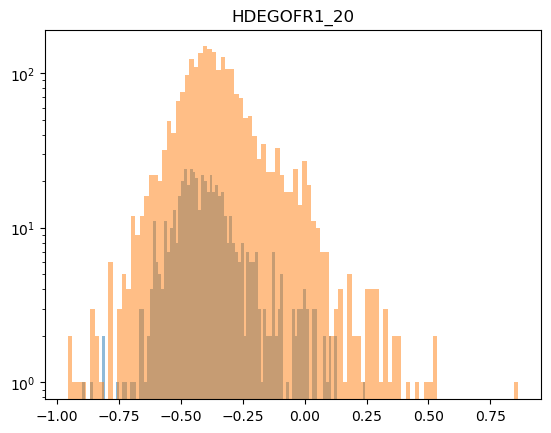

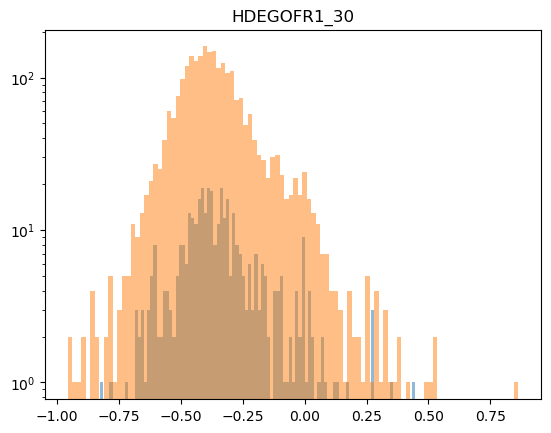

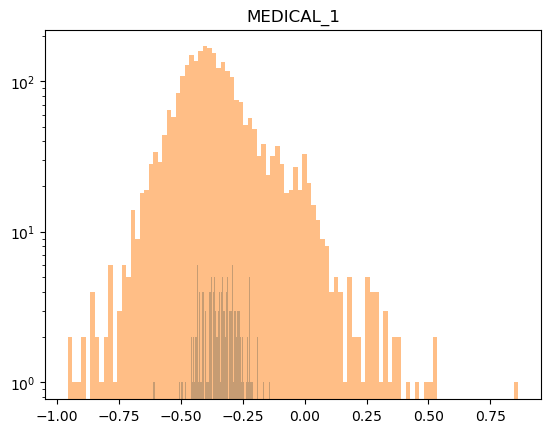

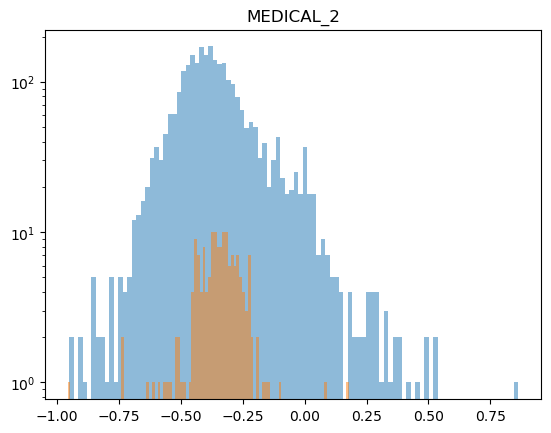

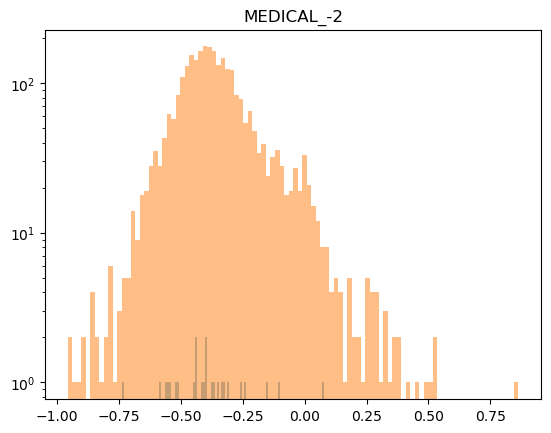

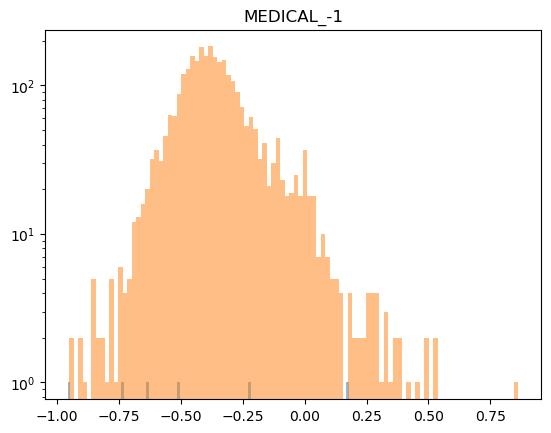

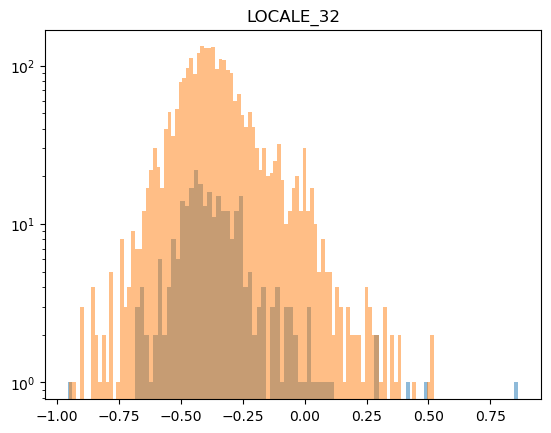

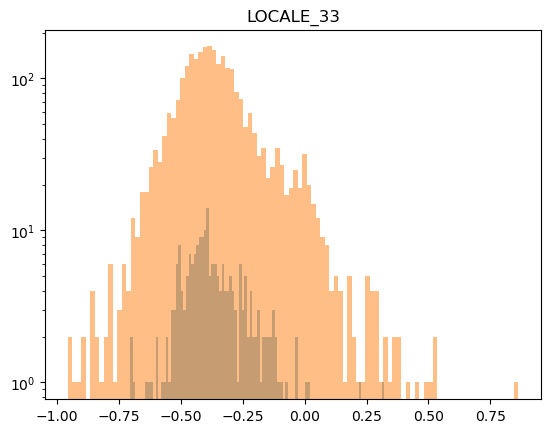

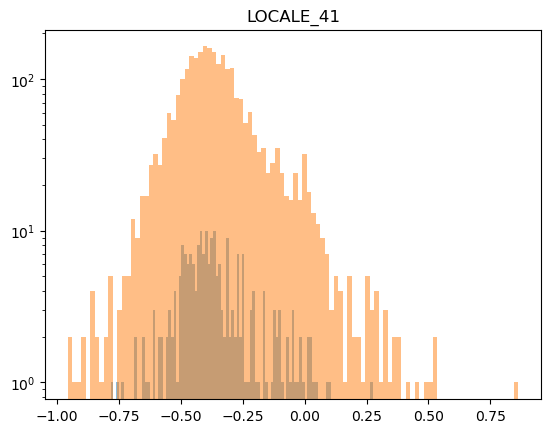

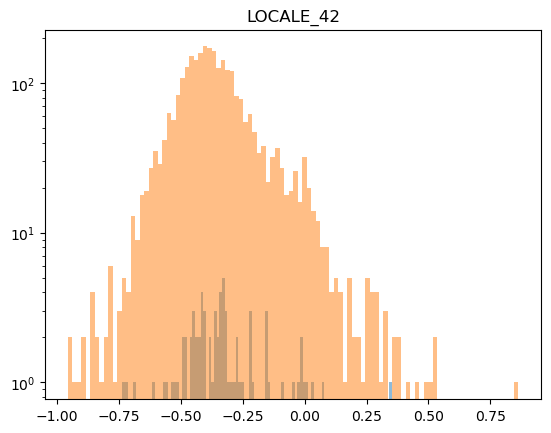

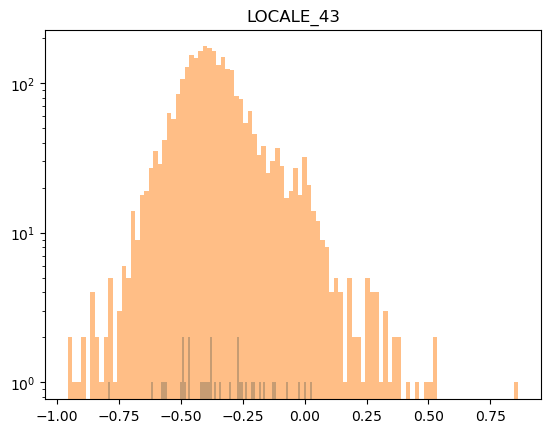

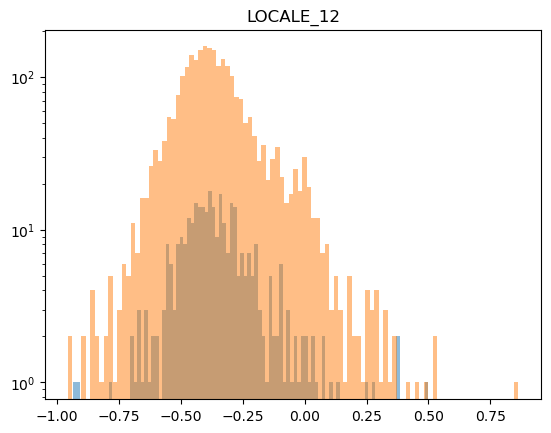

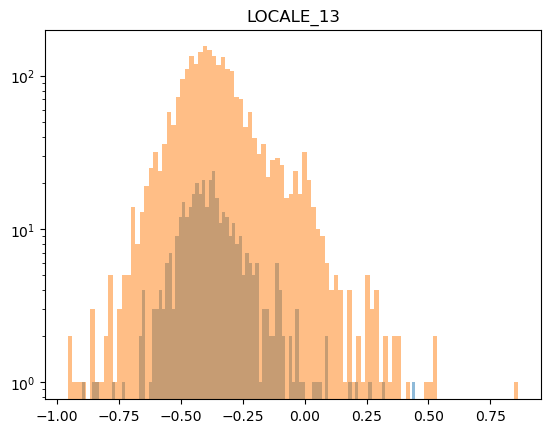

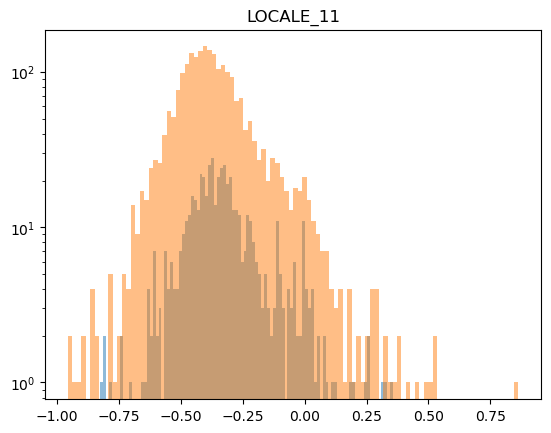

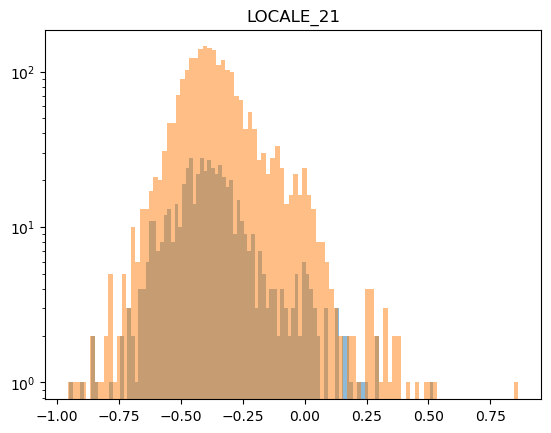

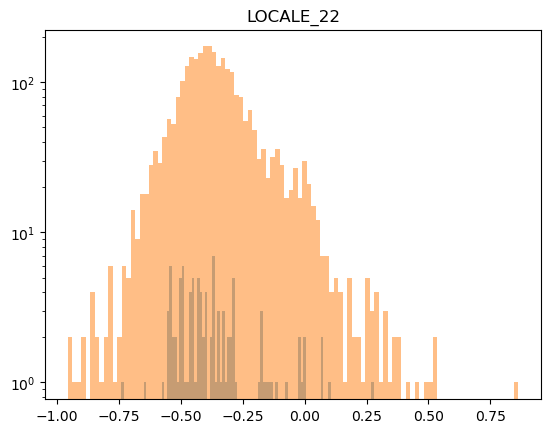

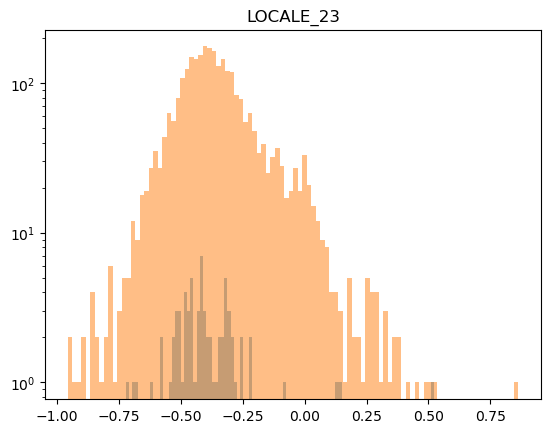

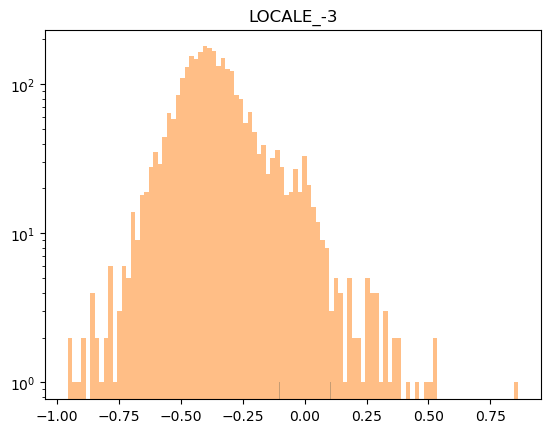

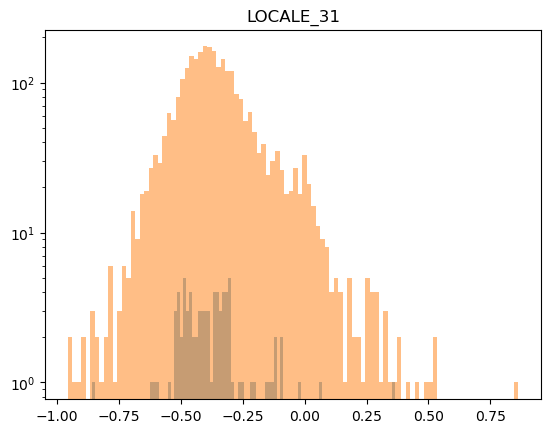

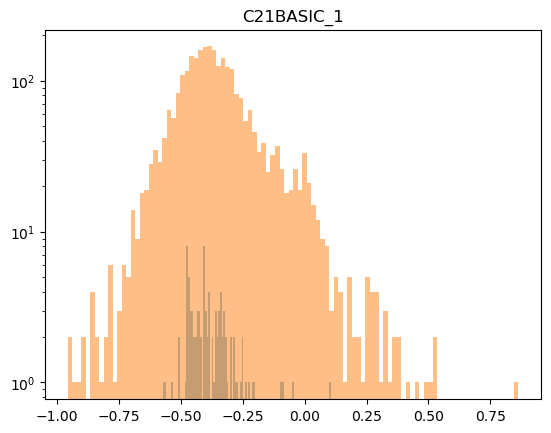

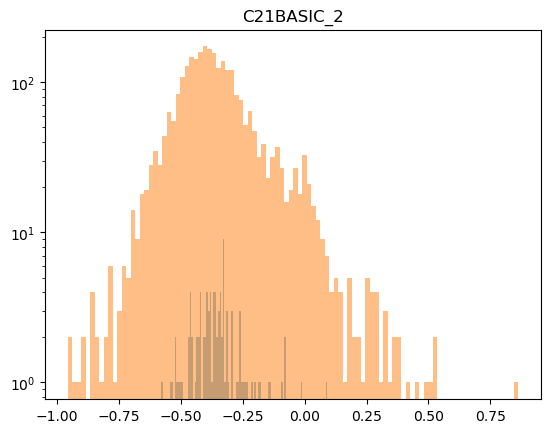

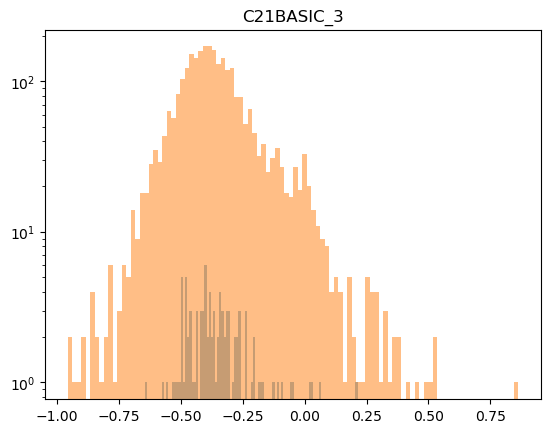

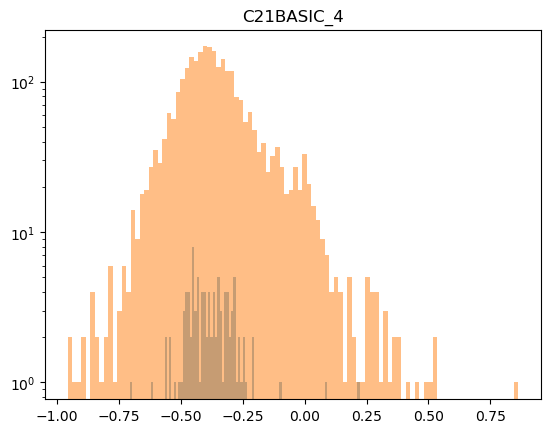

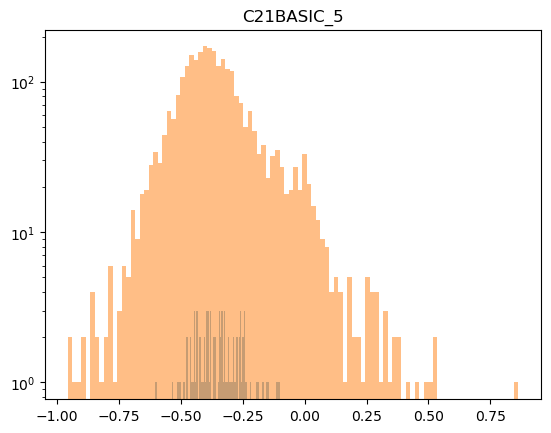

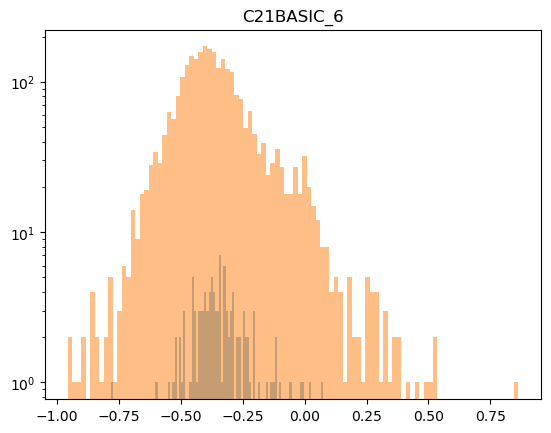

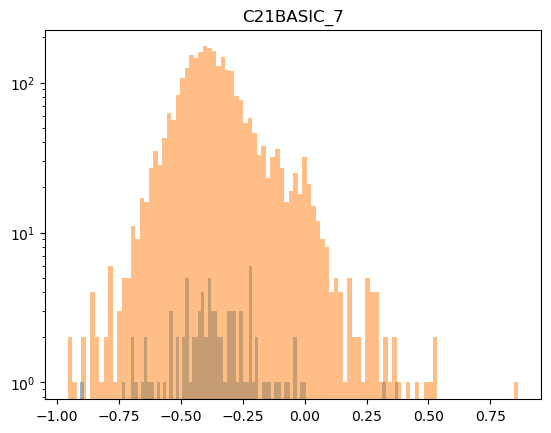

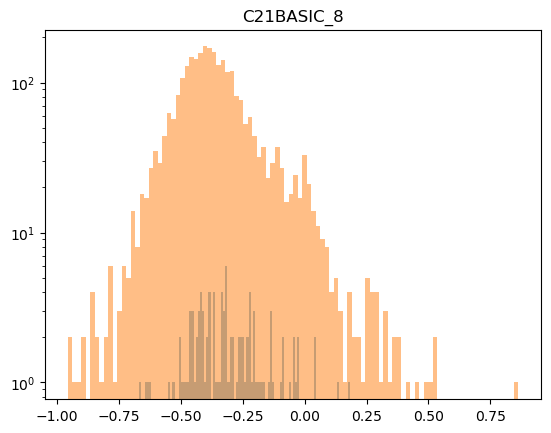

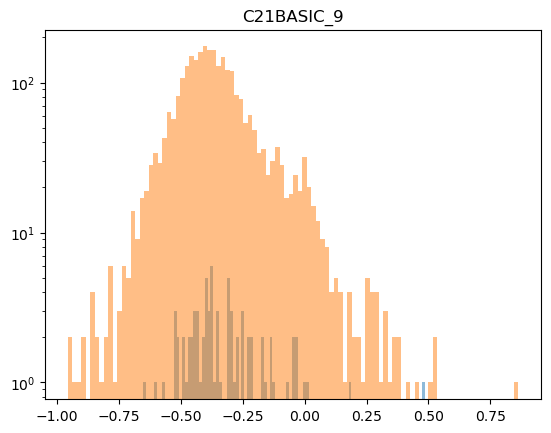

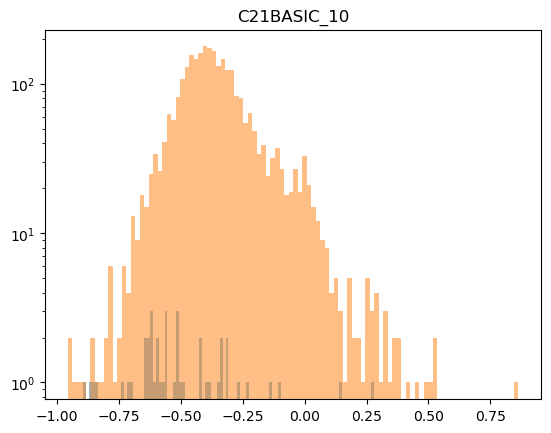

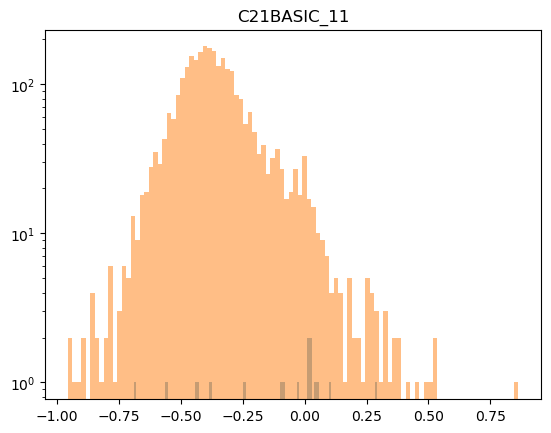

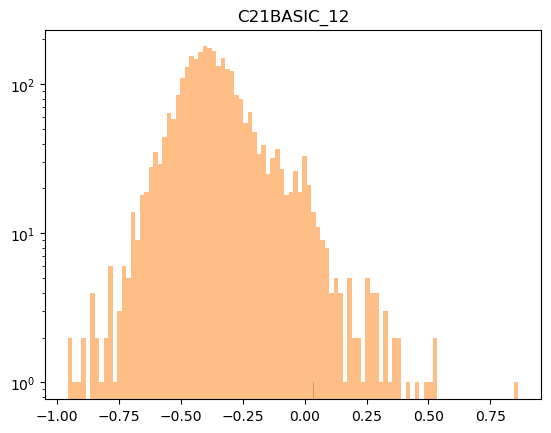

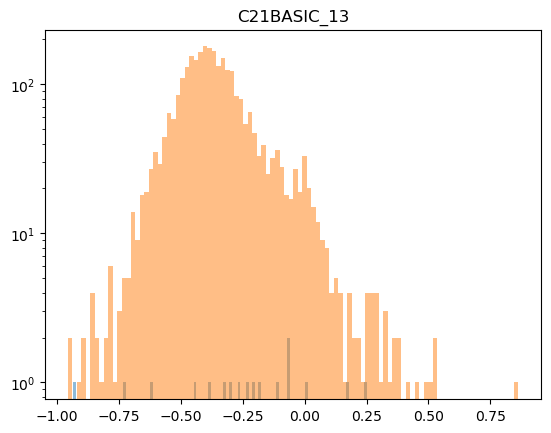

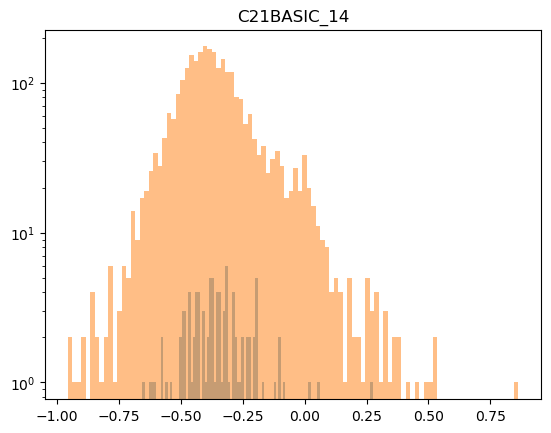

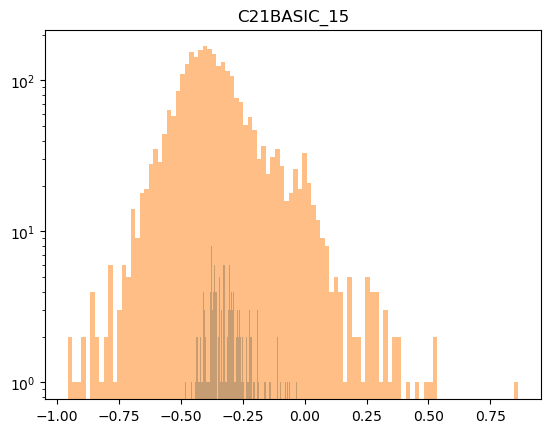

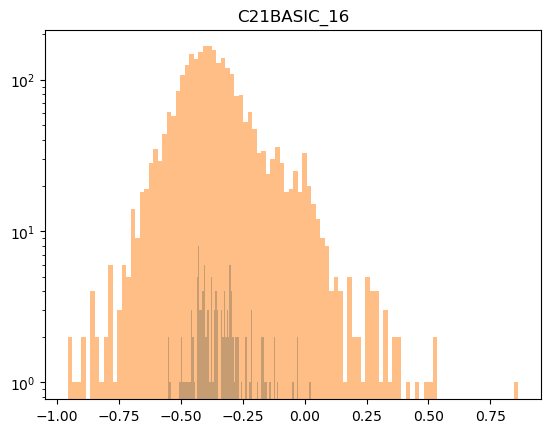

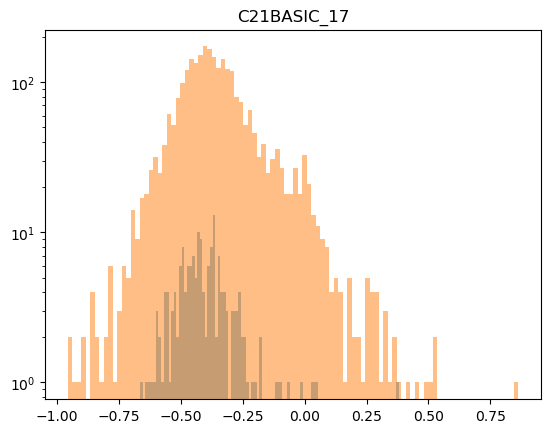

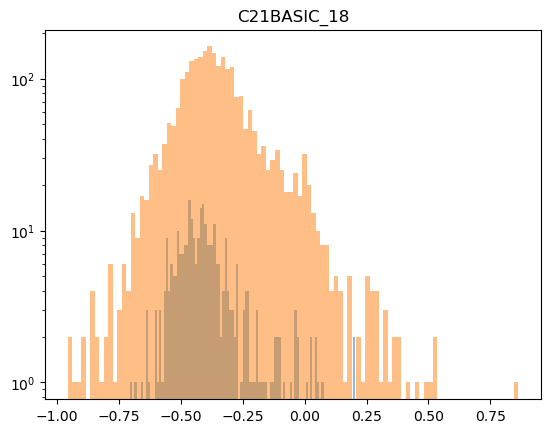

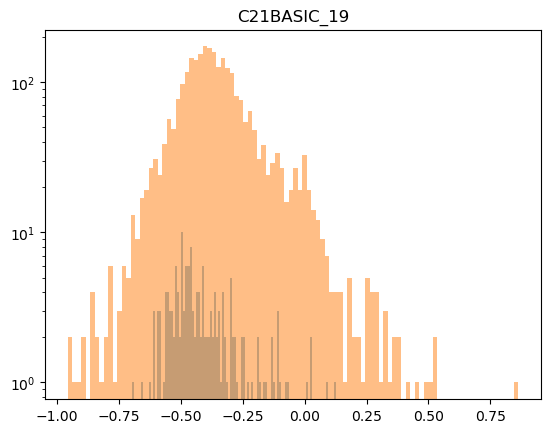

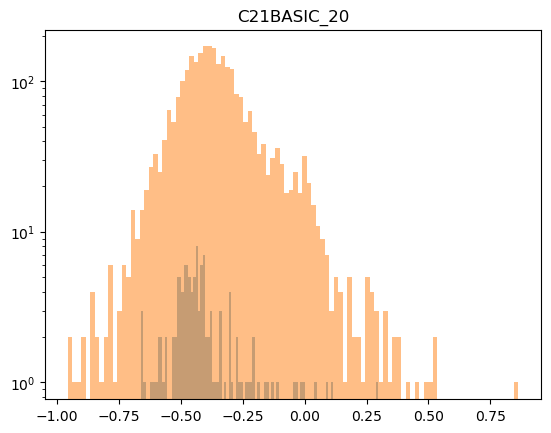

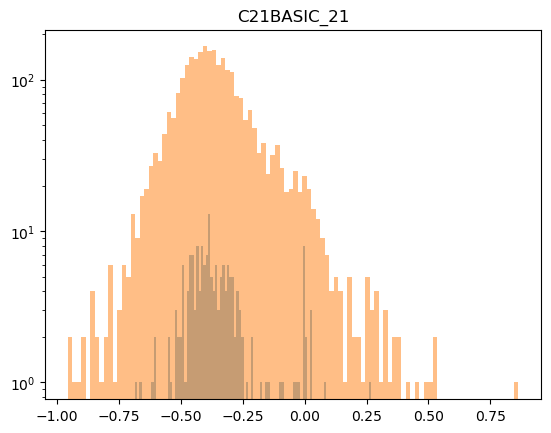

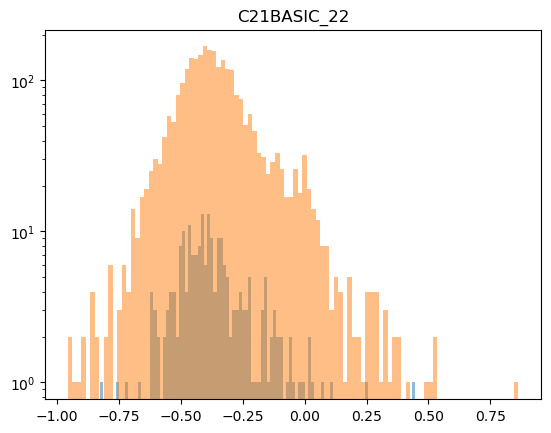

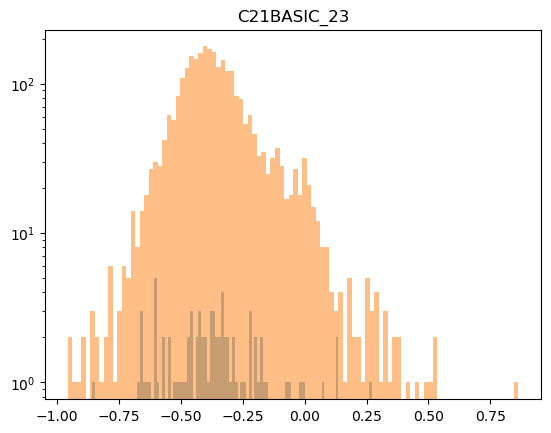

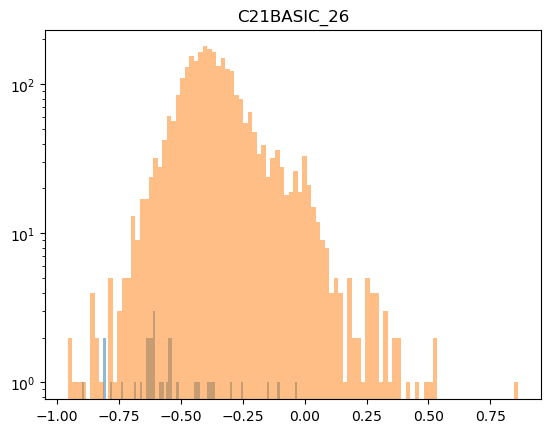

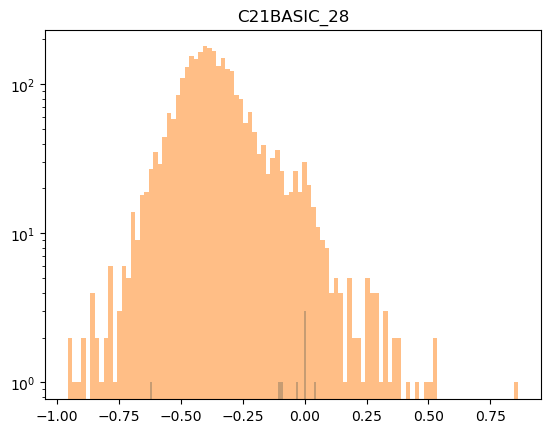

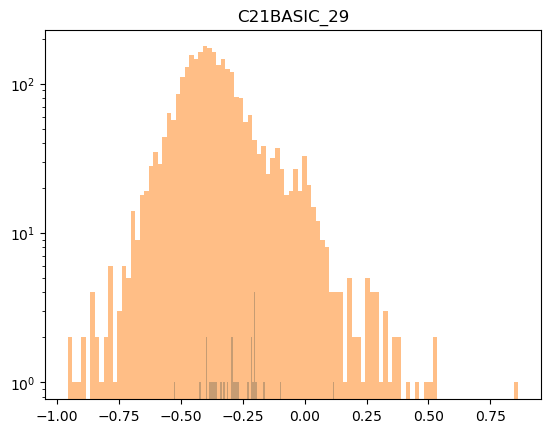

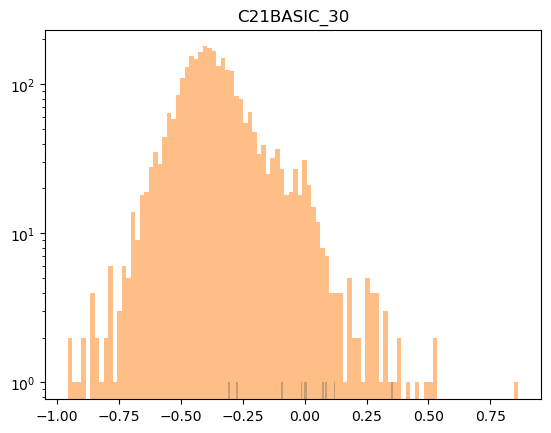

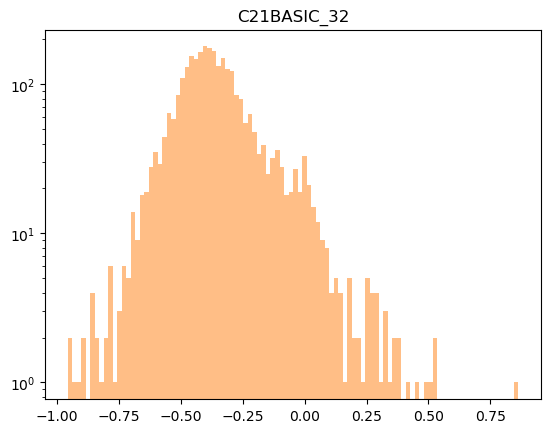

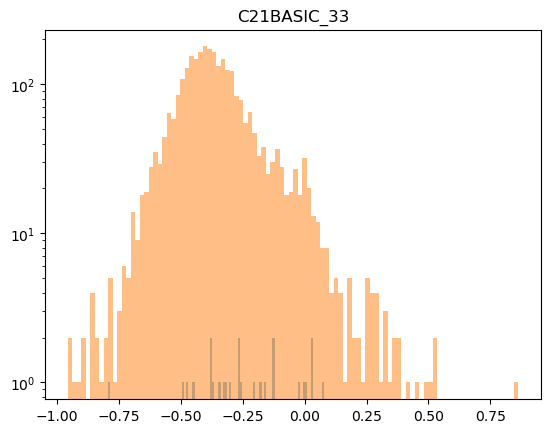

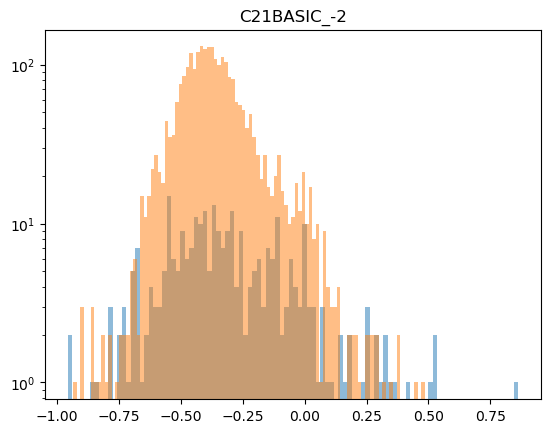

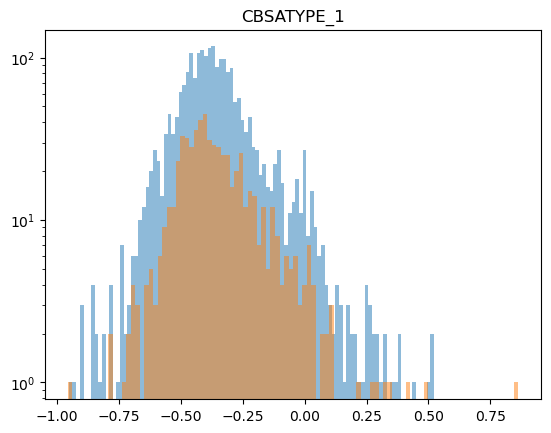

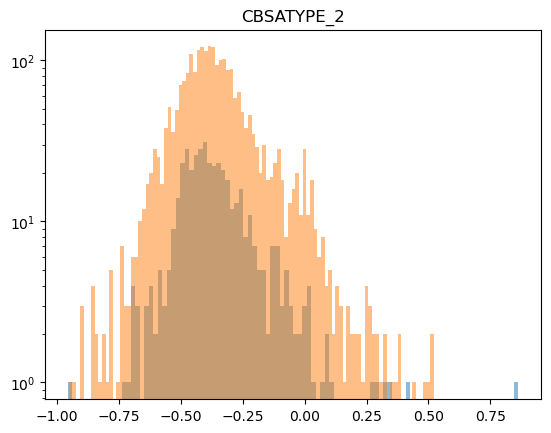

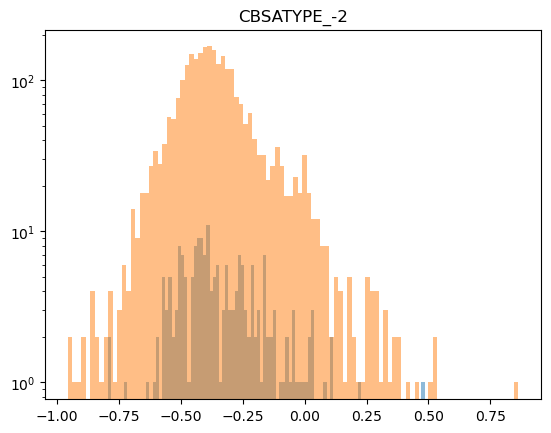

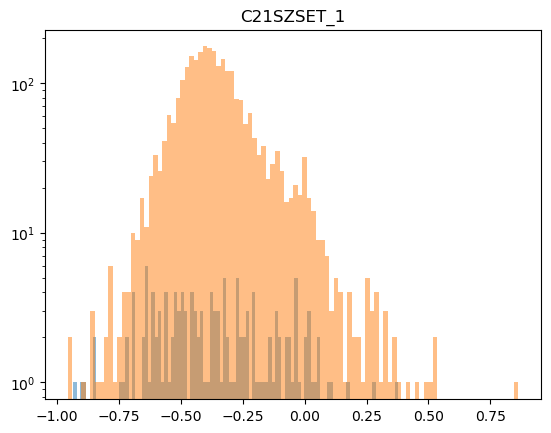

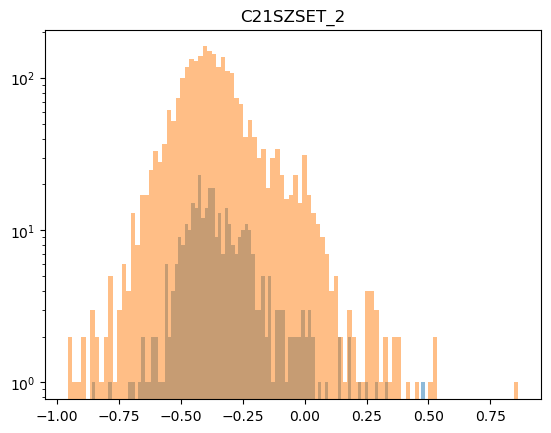

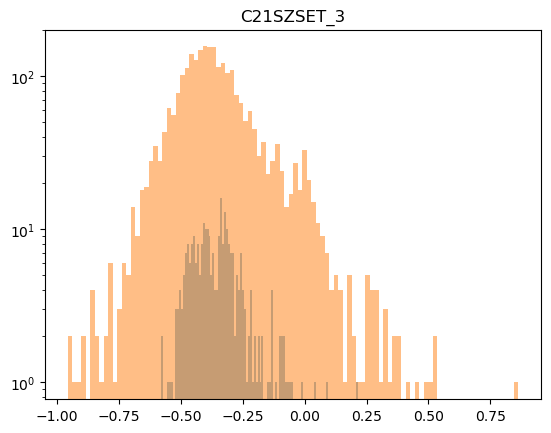

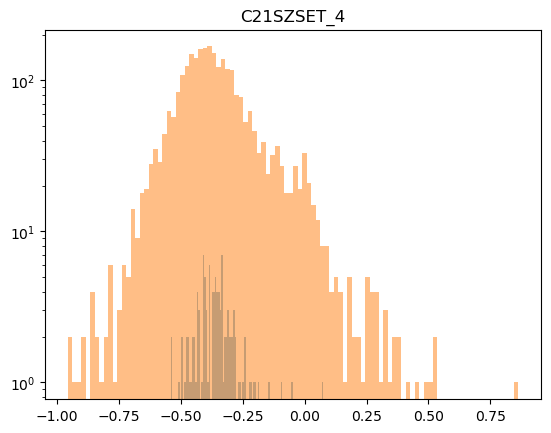

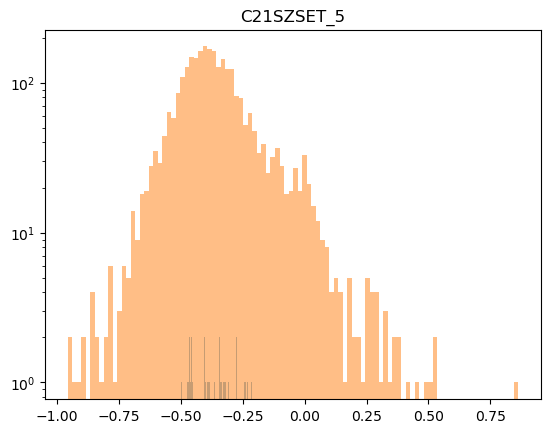

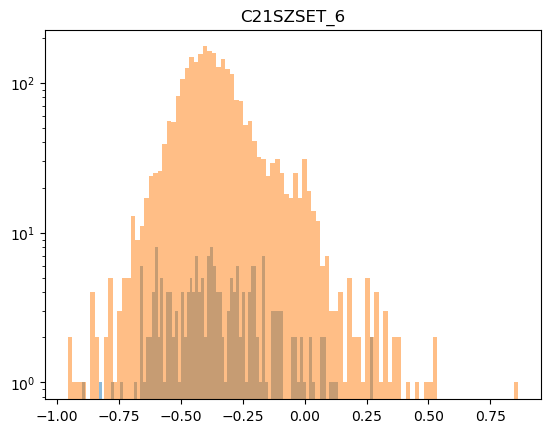

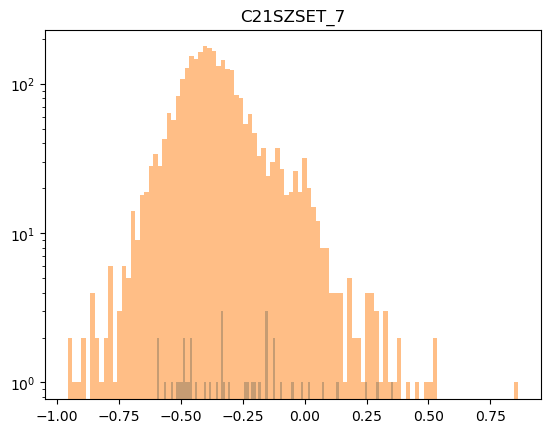

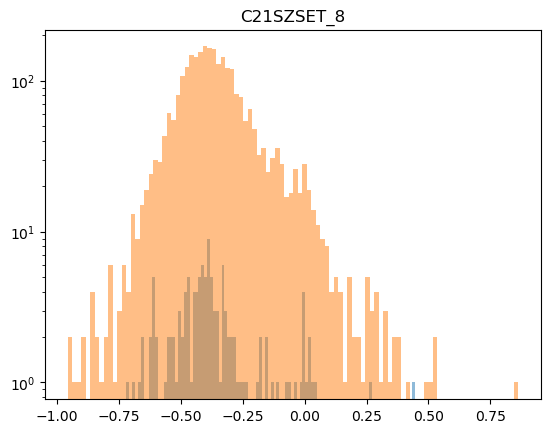

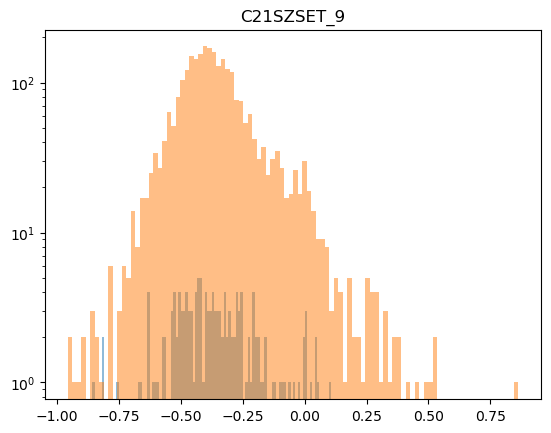

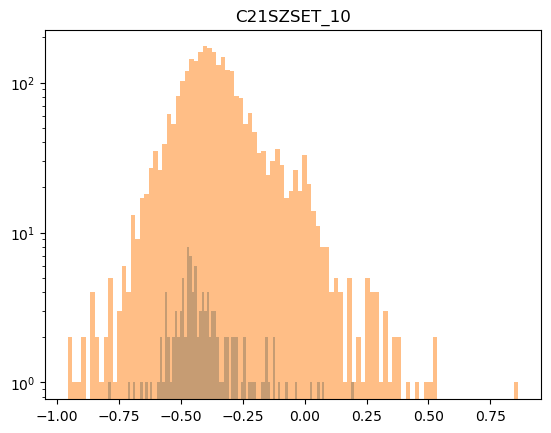

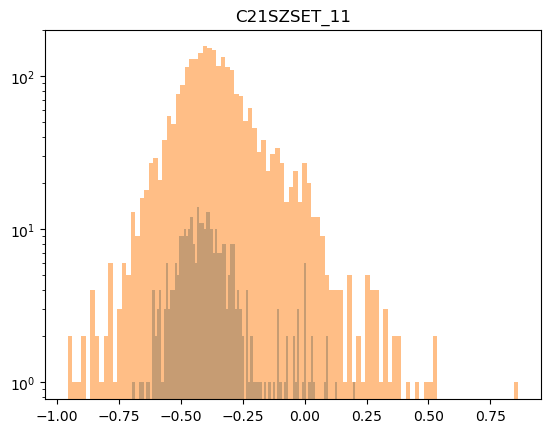

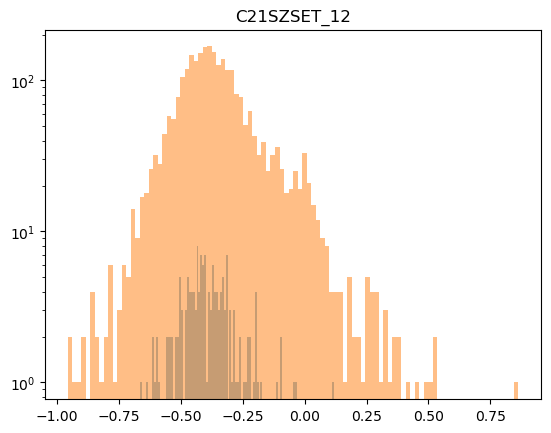

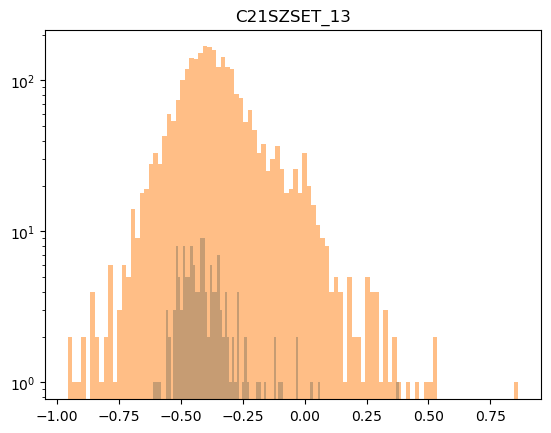

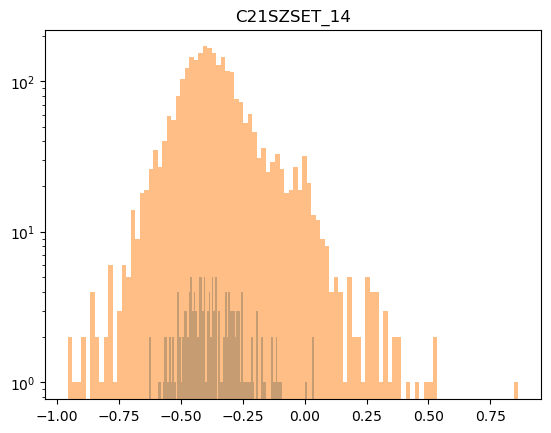

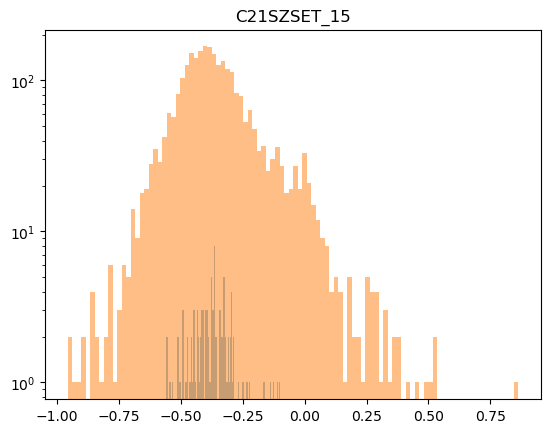

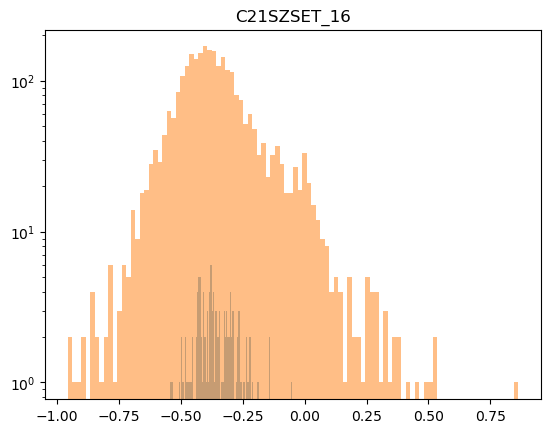

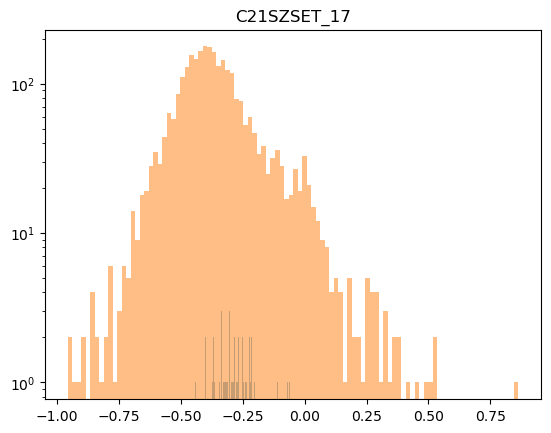

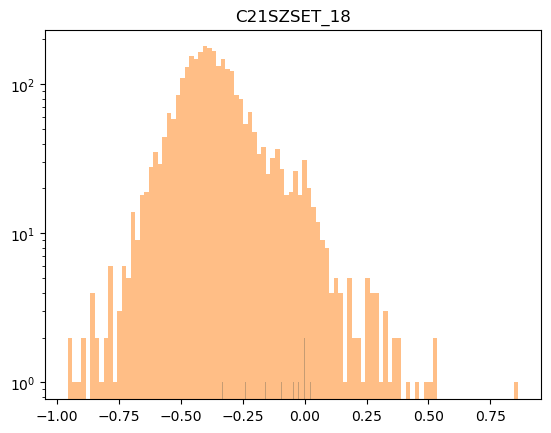

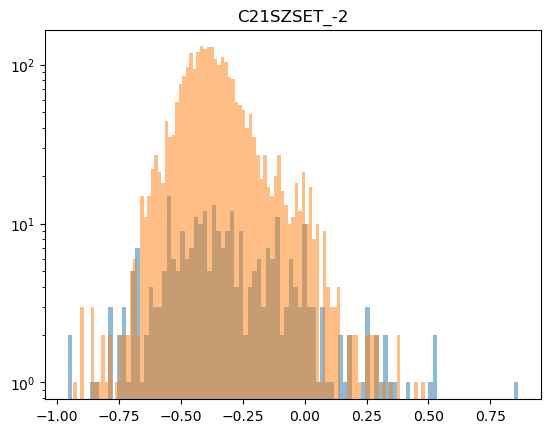

<Figure size 640x480 with 0 Axes>